# Import Repo of Sepsis Simulator

In [ ]:
!git clone https://github.com/clinicalml/gumbel-max-scm.git

Cloning into 'gumbel-max-scm'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 1.48 MiB | 3.81 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
#Enable importing code from parent directory
import os, sys
simulator_path = os.path.abspath('./gumbel-max-scm')
sys.path.insert(1, simulator_path)

In [ ]:
!pip install pymdptoolbox

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25657 sha256=1b7fb2ecdb2ff9a110c94e1be268b0dce4dd9b9655b99d17d6832b4b35ff6645
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox


**IMPORTANT NOTE:** At this stage, to reproduce our experiments, one must modify line 38 of `gumbel-max-scm/sepsisSimDiabetes/DataGenerator.py` so that it reads:

```
mdp = MDP(init_state_idx=%state%,
          policy_array=policy, policy_idx_type=policy_idx_type,
          p_diabetes=p_diabetes)

```

We have essentially set the initial state to a fixed value so that we may estimate the Q-function from that state. Additionally, line 58 of the same file must be modified to:

```
mdp.state = mdp.get_new_state(state_idx = %state%)
```

In [ ]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set up Variables and Functions

Code taken from [Oberst and Sontag](https://github.com/clinicalml/gumbel-max-scm/blob/master/plots-main-paper.ipynb).

Set up important variables

In [ ]:
SEED = 1
np.random.seed(SEED)
NSIMSAMPS = 100000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 5  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

# Option 1: Use bootstrapping w/replacement on the original NSIMSAMPS to estimate errors
USE_BOOSTRAP=True
N_BOOTSTRAP = 100

# Option 2: Use repeated sampling (i.e., NSIMSAMPS fresh simulations each time) to get error bars;
# This is done in the appendix of the paper, but not in the main paper
N_REPEAT_SAMPLING = 1

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
n_states_abs = State.NUM_OBS_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

# Number of runs for calculating MSE
RUNS = 20
# Number of episodes over which we average an OPE estimate
N = 1000

In [ ]:
hr_state_mapping = ['Low', 'Normal', 'High']
sbp_state_mapping = ['Low', 'Normal', 'High']
o2_state_mapping = ['Low', 'Normal']
glu_state_mapping = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
abx_state_mapping = ['Off', 'On']
vaso_state_mapping = ['Off', 'On']
vent_state_mapping = ['Off', 'On']
diab_state_mapping = ['No', 'Yes']

Set up base for behaviour and evaluation policies

In [ ]:
import zipfile
with zipfile.ZipFile("gumbel-max-scm/data/diab_txr_mats-replication.zip", 'r') as zip_ref:
    zip_ref.extractall("gumbel-max-scm/data")

In [ ]:
# Get the transition and reward matrix from file
with open("gumbel-max-scm/data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]

In [ ]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

# Easily accessible variables
A = n_actions
S = State.NUM_FULL_STATES

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [ ]:
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

#The behavior policy is the fully random policy
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

In [ ]:
#We want the expected reward of starting in a state and taking an action
R = np.swapaxes(np.mean(r_mat_full, axis=-1), 0, 1)
R.shape

(1440, 8)

In [ ]:
#To handle -1 states and -1 actions
def pad_policy(policy, val=1):
  #Add a column of zeroes to the end
  policy = np.concatenate((policy, np.full((policy.shape[0], 1), val)), axis=1)
  #Add a row of zeroes at the end
  policy = np.concatenate((policy, np.full((1, policy.shape[1]), val)), axis=0)
  return policy

# Load repo

In [ ]:
!git clone https://github.com/ai4ai-lab/Factored-Action-Spaces-for-OPE.git

Cloning into 'Factored-Action-Spaces-for-OPE'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 93 (delta 20), reused 71 (delta 7), pack-reused 0
Receiving objects: 100% (93/93), 2.94 MiB | 7.52 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
#Enable importing code from parent directory
import os, sys
main_folder = os.path.abspath('./Factored-Action-Spaces-for-OPE')
sys.path.insert(1, main_folder)

# From Patient State 136, With Diabetes

In [ ]:
#The patient has diabetes
PROB_DIAB = 1.0

### State Analysis

In [ ]:
#Instantiate a state based on the idx and get the state vector
testState = State(state_idx = 136, diabetic_idx=1)
vec = testState.get_state_vector()

print(vec)

print(f'Heart Rate: {hr_state_mapping[vec[0]]}')
print(f'Systolic Blood Pressure: {sbp_state_mapping[vec[1]]}')
print(f'Percent Oxygen: {o2_state_mapping[vec[2]]}')
print(f'Glucose Level: {glu_state_mapping[vec[3]]}')
print(f'Antibiotics: {abx_state_mapping[vec[4]]}')
print(f'Vasopressors: {vaso_state_mapping[vec[5]]}')
print(f'Ventilator: {vent_state_mapping[vec[6]]}')
print(f'Diabetes: {testState.diabetic_idx}')

[0 1 1 2 0 0 0]
Heart Rate: Low
Systolic Blood Pressure: Normal
Percent Oxygen: Normal
Glucose Level: Normal
Antibiotics: Off
Vasopressors: Off
Ventilator: Off
Diabetes: 1


### Generate Data From Behaviour Policy

Run the data generator

In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b.shape

(100000, 20, 5)

In [ ]:
print(nf_tr_b)

[[[  0. 136.   0.  -1. 168.]
  [  1. 168.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   3.  -1. 227.]
  [  1. 227.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.   0. 223.]
  [  1. 223.   3.   0. 219.]
  [  2. 219.   1.   0. 218.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 ...

 [[  0. 136.   2.   0. 377.]
  [  1. 377.   4.   0. 372.]
  [  2. 372.   7.   0. 463.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   5.   0. 222.]
  [  1. 222.   1.   0. 218.]
  [  2. 218.   7.  -1. 231.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.  -1. 231.]
  [  1. 231.  -1.   0.  -1.]
  [  2.  -1.  -1.   0.  -1

In [ ]:
randPol = pad_policy(randPol)

### Varying Episodes $\epsilon_{e} = 0.4$ (Policy Divergence $4.8^{20}$)

Set up evaluation policy, generate data and convert into factored format

In [ ]:
EVAL_EPSILON = 0.4

evalPolSoft = np.copy(fullPol)
evalPolSoft[evalPolSoft == 1] = 1 - EVAL_EPSILON
evalPolSoft[evalPolSoft == 0] = EVAL_EPSILON / (n_actions - 1)

In [ ]:
# Calculate policy divergence from Voloshin et al.
D = 0
for state in range(randPol.shape[0] - 1):
    for action in range(randPol.shape[1] - 1):
        difference = evalPolSoft[state, action]/randPol[state, action]
        D = max(D, difference)
print(D)
shorter_D = round(D,2)

4.8


In [ ]:
dgen = DataGenerator()
states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=evalPolSoft, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_e = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_e.shape

(100000, 20, 5)

In [ ]:
print(nf_tr_e)

[[[  0. 136.   0.   0. 136.]
  [  1. 136.   2.   0.  57.]
  [  2.  57.   3.  -1. 227.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   2.   0.  57.]
  [  1.  57.   4.  -1.  68.]
  [  2.  68.  -1.   0.  -1.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   2.   0. 449.]
  [  1. 449.   5.   0. 462.]
  [  2. 462.   7.   0. 471.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 ...

 [[  0. 136.   2.   0. 145.]
  [  1. 145.   3.   0. 147.]
  [  2. 147.   2.   0.  57.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   7.   0. 223.]
  [  1. 223.   6.   0. 221.]
  [  2. 221.   4.   0. 132.]
  ...
  [ 17.  -1.  -1.   0.  -1.]
  [ 18.  -1.  -1.   0.  -1.]
  [ 19.  -1.  -1.   0.  -1.]]

 [[  0. 136.   2.   0.  57.]
  [  1.  57.   3.   0. 147.]
  [  2. 147.   2.   0. 145

In [ ]:
import policy_estimators as pe

#Obtain on policy estimate
on_policy_estimate = pe.on_policy_Q_estimate(nf_tr_e, DISCOUNT_Pol)

Plan

- Given data
- Objective: lower MSE with respect to on-policy estimate

- Evaluate on-policy estimate (true value)
- COnstruct a neural network to accept the action and state and output the decomposed policy values and decomposed rewards (2D outputs)
- Pass data through network in batches(runs) and based on this find the MSE
- Attempt to backpropagate through the network and ultimately obtain the best mapping.

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

true_val = torch.as_tensor(on_policy_estimate).to(device)

Using cuda device


Using states and actions

In [ ]:
#Takes in action and state
class FactorNetwork_sa(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 15),
            nn.ReLU(),
            nn.Linear(15, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
def train_loop_sa(model, loss_fn, optimizer, discount_factor):
    BATCH_SIZE = 1000
    train_data = nf_tr_b.reshape((-1, BATCH_SIZE, NSTEPS, 5))
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #List to hold losses
    losses = [0]*10
    for run in range(train_data.shape[0]):
      loss = torch.zeros((1), dtype=torch.float32).to(device)
      batch = train_data[run, :, :, :]
      for n in range(BATCH_SIZE):
        episode = batch[n, :, :]
        #Filter out -1 states and actions
        episode = episode[episode[:, 2] != -1, :]
        states_and_actions = torch.as_tensor(episode[:, 1:3], dtype=torch.float32).to(device)
        # Compute prediction and loss
        factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
        D = list(factored_pol_reward.size())[-1]//3
        factored_pi_b = factored_pol_reward[:, :D]
        factored_pi_e = factored_pol_reward[:, D:2*D]
        factored_reward = factored_pol_reward[:, 2*D:]

        fn = nn.ReLU()
        #Penalty for behaviour policy values < 1
        penalty1 = torch.sum(fn(torch.neg(factored_pi_b))).to(device)
        #Penalty for behaviour policy values < 1
        penalty2 = torch.sum(fn(torch.neg(factored_pi_e))).to(device)
        total_penalty = torch.add(penalty1, penalty2).div(episode.shape[0])

        pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
        IS_ratios = torch.prod(pointwise_IS_ratios, 0)

        times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
        # Per-trajectory returns (discounted cumulative rewards)
        gamma = torch.full(times.shape, discount_factor).to(device)
        G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

        loss.to(device)
        loss = torch.add(loss, torch.add(loss_fn(true_val, G), total_penalty).div(BATCH_SIZE))

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if run % 10 == 0:
          loss, current = loss.item(), (run + 1) * BATCH_SIZE
          print(f"loss: {loss:>7f}  [{run:>5d} /{train_data.shape[0]:>5d}]")
          losses[run//10] = loss
    return losses

In [ ]:
model1 = FactorNetwork_sa(2).to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)

epochs = 70
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_sa(model1, loss_fn, optimizer, DISCOUNT_Pol)

Epoch 1
-------------------------------
loss: 910.432495  [    0 /  100]
loss: 560.977600  [   10 /  100]
loss: 703.775940  [   20 /  100]
loss: 388.937561  [   30 /  100]
loss: 362.888672  [   40 /  100]
loss: 316.445068  [   50 /  100]
loss: 249.060532  [   60 /  100]
loss: 205.999695  [   70 /  100]
loss: 108.628403  [   80 /  100]
loss: 93.880798  [   90 /  100]
Epoch 2
-------------------------------
loss: 77.497688  [    0 /  100]
loss: 44.504601  [   10 /  100]
loss: 48.481956  [   20 /  100]
loss: 26.869720  [   30 /  100]
loss: 23.171932  [   40 /  100]
loss: 19.335766  [   50 /  100]
loss: 15.845043  [   60 /  100]
loss: 14.151194  [   70 /  100]
loss: 11.218729  [   80 /  100]
loss: 11.059662  [   90 /  100]
Epoch 3
-------------------------------
loss: 10.580872  [    0 /  100]
loss: 9.576029  [   10 /  100]
loss: 9.729786  [   20 /  100]
loss: 9.059988  [   30 /  100]
loss: 8.978627  [   40 /  100]
loss: 8.893556  [   50 /  100]
loss: 8.741565  [   60 /  100]
loss: 8.63065

In [ ]:
model2 = FactorNetwork_sa(3).to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

epochs = 70
losses_m2 = [0]*(epochs*10)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses_m2[t*10:(t+1)*10] = train_loop_sa(model2, loss_fn, optimizer, DISCOUNT_Pol)

Epoch 1
-------------------------------
loss: 31.281918  [    0 /  100]
loss: 2.077369  [   10 /  100]
loss: 0.383725  [   20 /  100]
loss: 0.592664  [   30 /  100]
loss: 0.356680  [   40 /  100]
loss: 0.207474  [   50 /  100]
loss: 0.209249  [   60 /  100]
loss: 0.210642  [   70 /  100]
loss: 0.237120  [   80 /  100]
loss: 0.191882  [   90 /  100]
Epoch 2
-------------------------------
loss: 0.216831  [    0 /  100]
loss: 0.195013  [   10 /  100]
loss: 0.197001  [   20 /  100]
loss: 0.207180  [   30 /  100]
loss: 0.199999  [   40 /  100]
loss: 0.195448  [   50 /  100]
loss: 0.202571  [   60 /  100]
loss: 0.201161  [   70 /  100]
loss: 0.234590  [   80 /  100]
loss: 0.188575  [   90 /  100]
Epoch 3
-------------------------------
loss: 0.212971  [    0 /  100]
loss: 0.192249  [   10 /  100]
loss: 0.194002  [   20 /  100]
loss: 0.204227  [   30 /  100]
loss: 0.196321  [   40 /  100]
loss: 0.192542  [   50 /  100]
loss: 0.199242  [   60 /  100]
loss: 0.196735  [   70 /  100]
loss: 0.228

Using policy and reward

In [ ]:
#Takes in policy values and reward at state and action
class FactorNetwork_pr(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 3*D),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
def train_loop_pr(model, loss_fn, optimizer, discount_factor, pi_b, pi_e):
    BATCH_SIZE = 1000
    train_data = nf_tr_b.reshape((-1, BATCH_SIZE, NSTEPS, 5))
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    #List to hold losses
    losses = [0]*10
    for run in range(train_data.shape[0]):
      loss = torch.zeros((1), dtype=torch.float32).to(device)
      batch = train_data[run, :, :, :]
      for n in range(BATCH_SIZE):
        episode = batch[n, :, :]
        #Filter out -1 states and actions
        episode = episode[episode[:, 2] != -1, :]
        S = episode[:, 1].astype('int32')
        A = episode[:,2].astype('int32')
        states_and_actions = torch.as_tensor(np.stack((pi_b[S, A], pi_e[S, A], episode[:,3]), axis=-1), dtype=torch.float32).to(device)
        # Compute prediction and loss
        factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
        D = list(factored_pol_reward.size())[-1]//3
        factored_pi_b = factored_pol_reward[:, :D]
        factored_pi_e = factored_pol_reward[:, D:2*D]
        factored_reward = factored_pol_reward[:, 2*D:]

        fn = nn.ReLU()
        #Penalty for behaviour policy values < 1
        penalty1 = torch.sum(fn(torch.neg(factored_pi_b))).to(device)
        #Penalty for behaviour policy values < 1
        penalty2 = torch.sum(fn(torch.neg(factored_pi_e))).to(device)
        total_penalty = torch.add(penalty1, penalty2).div(episode.shape[0])

        pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
        IS_ratios = torch.prod(pointwise_IS_ratios, 0)

        times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
        # Per-trajectory returns (discounted cumulative rewards)
        gamma = torch.full(times.shape, discount_factor).to(device)
        G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

        loss.to(device)
        loss = torch.add(loss, torch.add(loss_fn(true_val, G), total_penalty).div(BATCH_SIZE))

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if run % 10 == 0:
          loss, current = loss.item(), (run + 1) * BATCH_SIZE
          print(f"loss: {loss:>7f}  [{run:>5d} /{train_data.shape[0]:>5d}]")
          losses[run//10] = loss
    return losses

In [ ]:
model3 = FactorNetwork_pr(2).to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

epochs = 70
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_pr(model3, loss_fn, optimizer, DISCOUNT_Pol, randPol, evalPolSoft)

Epoch 1
-------------------------------
loss: 0.008138  [    0 /  100]
loss: 0.007609  [   10 /  100]
loss: 0.010534  [   20 /  100]
loss: 0.008381  [   30 /  100]
loss: 0.008179  [   40 /  100]
loss: 0.011056  [   50 /  100]
loss: 0.009743  [   60 /  100]
loss: 0.007587  [   70 /  100]
loss: 0.012430  [   80 /  100]
loss: 0.011529  [   90 /  100]
Epoch 2
-------------------------------
loss: 0.007857  [    0 /  100]
loss: 0.007291  [   10 /  100]
loss: 0.010218  [   20 /  100]
loss: 0.008046  [   30 /  100]
loss: 0.007954  [   40 /  100]
loss: 0.010700  [   50 /  100]
loss: 0.009365  [   60 /  100]
loss: 0.007323  [   70 /  100]
loss: 0.011955  [   80 /  100]
loss: 0.011143  [   90 /  100]
Epoch 3
-------------------------------
loss: 0.007626  [    0 /  100]
loss: 0.007037  [   10 /  100]
loss: 0.009940  [   20 /  100]
loss: 0.007792  [   30 /  100]
loss: 0.007750  [   40 /  100]
loss: 0.010409  [   50 /  100]
loss: 0.009052  [   60 /  100]
loss: 0.007098  [   70 /  100]
loss: 0.0115

In [ ]:
model4 = FactorNetwork_pr(3).to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.0001)

epochs = 40
losses_m4 = [0]*epochs*10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses_m4[t*10:(t+1)*10] = train_loop_pr(model4, loss_fn, optimizer, DISCOUNT_Pol, randPol, evalPolSoft)

Epoch 1
-------------------------------
loss: 6.580877  [    0 /  100]
loss: 5.748127  [   10 /  100]
loss: 6.489702  [   20 /  100]
loss: 5.572906  [   30 /  100]
loss: 5.607388  [   40 /  100]
loss: 5.423065  [   50 /  100]
loss: 5.160678  [   60 /  100]
loss: 5.434678  [   70 /  100]
loss: 4.825305  [   80 /  100]
loss: 4.763486  [   90 /  100]
Epoch 2
-------------------------------
loss: 4.846787  [    0 /  100]
loss: 4.263735  [   10 /  100]
loss: 4.725530  [   20 /  100]
loss: 4.094279  [   30 /  100]
loss: 4.091607  [   40 /  100]
loss: 3.936630  [   50 /  100]
loss: 3.736750  [   60 /  100]
loss: 3.888947  [   70 /  100]
loss: 3.472434  [   80 /  100]
loss: 3.404456  [   90 /  100]
Epoch 3
-------------------------------
loss: 3.425740  [    0 /  100]
loss: 3.044214  [   10 /  100]
loss: 3.296467  [   20 /  100]
loss: 2.889802  [   30 /  100]
loss: 2.862955  [   40 /  100]
loss: 2.736969  [   50 /  100]
loss: 2.586803  [   60 /  100]
loss: 2.627303  [   70 /  100]
loss: 2.3342

In [ ]:
model5 = FactorNetwork_pr(4).to(device)

loss_fn = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001)

epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_pr(model5, loss_fn, optimizer, DISCOUNT_Pol, randPol, evalPolSoft)

Epoch 1
-------------------------------
loss: 1.751205  [    0 /  100]
loss: 1.670108  [   10 /  100]
loss: 1.620225  [   20 /  100]
loss: 1.548632  [   30 /  100]
loss: 1.493559  [   40 /  100]
loss: 1.436204  [   50 /  100]
loss: 1.382522  [   60 /  100]
loss: 1.329095  [   70 /  100]
loss: 1.289697  [   80 /  100]
loss: 1.252048  [   90 /  100]
Epoch 2
-------------------------------
loss: 1.217517  [    0 /  100]
loss: 1.187078  [   10 /  100]
loss: 1.153870  [   20 /  100]
loss: 1.124950  [   30 /  100]
loss: 1.095177  [   40 /  100]
loss: 1.077855  [   50 /  100]
loss: 1.055181  [   60 /  100]
loss: 1.020875  [   70 /  100]
loss: 1.005256  [   80 /  100]
loss: 0.994949  [   90 /  100]
Epoch 3
-------------------------------
loss: 0.990857  [    0 /  100]
loss: 0.960694  [   10 /  100]
loss: 0.970160  [   20 /  100]
loss: 0.930605  [   30 /  100]
loss: 0.914517  [   40 /  100]
loss: 0.912141  [   50 /  100]
loss: 0.896678  [   60 /  100]
loss: 0.878795  [   70 /  100]
loss: 0.8609

Generate a new batch of behaviour data

Run the data generator

In [ ]:
randPol = np.ones(fullPol.shape)/(fullPol.shape[1])

states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
    NSIMSAMPS, NSTEPS, policy=randPol, policy_idx_type='full',
    p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

obs_samps = utils.format_dgen_samps(
    states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

Convert data into array format

In [ ]:
time = np.arange(NSTEPS)
times = np.stack(axis=0, arrays=[time]*NSIMSAMPS)
times = times[..., np.newaxis]

nf_tr_b2 = np.concatenate((times, states[:, 0:NSTEPS, :], actions, rewards, states[:, 1:, :]), axis=2)
nf_tr_b2.shape

(100000, 20, 5)

In [ ]:
def test_model_sa(model):
  test_data = nf_tr_b2
  model.eval()
  loss = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    states_and_actions = torch.as_tensor(episode[:, 1:3], dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, DISCOUNT_Pol).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    loss.to(device)
    loss = torch.add(loss, loss_fn(true_val, G).div(test_data.shape[0]))
  return loss

In [ ]:
test_model_sa(model1)

tensor([0.1903], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
torch.save(model1.state_dict(), './model1e004')

In [ ]:
print(test_model_sa(model2))

tensor([0.1849], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
torch.save(model2.state_dict(), './model2e004')

In [ ]:
def test_model_rp(model, pi_b, pi_e, discount_factor):
  test_data = nf_tr_b2
  model.eval()
  loss = torch.zeros((1), dtype=torch.float32).to(device)
  for run in range(test_data.shape[0]):
    episode = test_data[run, :, :]
    #Filter out -1 states and actions
    episode = episode[episode[:, 2] != -1, :]
    S = episode[:, 1].astype('int32')
    A = episode[:,2].astype('int32')
    states_and_actions = torch.as_tensor(np.stack((pi_b[S, A], pi_e[S, A], episode[:,3]), axis=-1), dtype=torch.float32).to(device)
    # Compute prediction and loss
    factored_pol_reward = model(states_and_actions) #Use predictions from network to calculate OPE estimates
    D = list(factored_pol_reward.size())[-1]//3
    factored_pi_b = factored_pol_reward[:, :D]
    factored_pi_e = factored_pol_reward[:, D:2*D]
    factored_reward = factored_pol_reward[:, 2*D:]

    pointwise_IS_ratios = torch.div(factored_pi_e, factored_pi_b)
    IS_ratios = torch.prod(pointwise_IS_ratios, 0)

    times = torch.as_tensor(np.repeat(np.expand_dims(episode[:, 0], axis=1), D, axis=1)).to(device)
    # Per-trajectory returns (discounted cumulative rewards)
    gamma = torch.full(times.shape, discount_factor).to(device)
    G = torch.mul(factored_reward, torch.pow(gamma, times)).sum()

    loss.to(device)
    loss = torch.add(loss, loss_fn(true_val, G).div(test_data.shape[0]))
  return loss

In [ ]:
print(test_model_rp(model3, randPol, evalPolSoft, DISCOUNT_Pol))

tensor([0.0075], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
print(test_model_rp(model4, randPol, evalPolSoft, DISCOUNT_Pol))

tensor([0.0029], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
print(test_model_rp(model5, randPol, evalPolSoft, DISCOUNT_Pol))

tensor([0.0029], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
torch.save(model3.state_dict(), './model3e004')

In [ ]:
torch.save(model4.state_dict(), './model4e004')

In [ ]:
torch.save(model5.state_dict(), './model5e004')

#### Plotting Graphs

##### Model 2

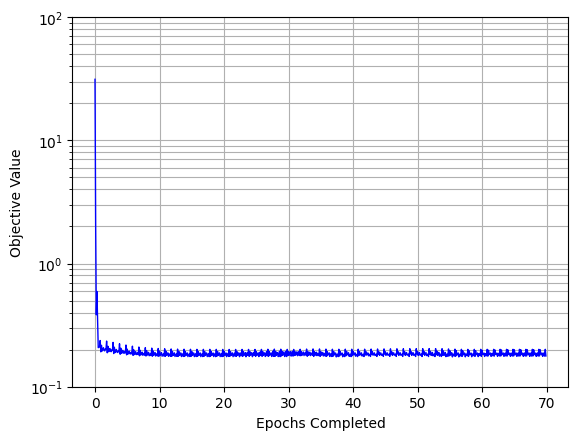

In [ ]:
y_axis = losses_m2
x_axis = np.arange(0, 70, 0.1)


plt.plot(x_axis, y_axis, color='b', linewidth=1.0)
plt.grid(visible=True, which='both', axis='both')
plt.yscale("log")
plt.xlabel('Epochs Completed')
plt.ylabel('Objective Value')
plt.ylim([10**(-1), 100])
plt.savefig(f'model-2-learning-curve.pdf', dpi=300)
plt.show()

##### Model 3

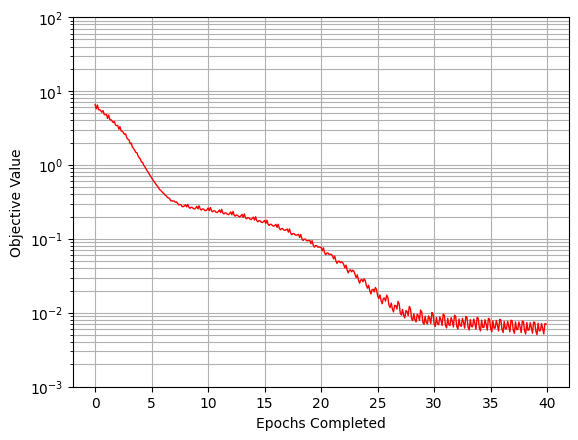

In [ ]:
y_axis = losses_m4
x_axis = np.arange(0, 40, 0.1)


plt.plot(x_axis, y_axis, color='r', linewidth=1.0)
plt.grid(visible=True, which='both', axis='both')
plt.yscale("log")
plt.xlabel('Epochs Completed')
plt.ylabel('Objective Value')
plt.ylim([10**(-3), 100])
plt.savefig(f'model-4-learning-curve.pdf', dpi=300)
plt.show()